In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image

from torch.utils.data import TensorDataset, DataLoader


In [2]:
from mnist_loader import load_mnist, plot_images

n_data, train_images, train_labels, test_images, test_labels = load_mnist()

<>:10: SyntaxWarning: invalid escape sequence '\i'
<>:25: SyntaxWarning: invalid escape sequence '\i'
<>:10: SyntaxWarning: invalid escape sequence '\i'
<>:25: SyntaxWarning: invalid escape sequence '\i'
/var/folders/06/9qrhxzd12j19fybr2l6xdv_h0000gn/T/ipykernel_42990/3426079466.py:10: SyntaxWarning: invalid escape sequence '\i'
  # currently the latent vector is 2D for testing
/var/folders/06/9qrhxzd12j19fybr2l6xdv_h0000gn/T/ipykernel_42990/3426079466.py:25: SyntaxWarning: invalid escape sequence '\i'
  we approximate this using this encoder neural network q(z | x) = N(z | mu, sigma * I), where z \in R^latent_dim


--Batch      0 loss: 1.1099e-01, recon_loss: 1.0755e-01, kl_loss: 3.4355e-03
--Batch    100 loss: 7.1811e-02, recon_loss: 7.1805e-02, kl_loss: 5.4138e-06
--Batch    200 loss: 7.2493e-02, recon_loss: 7.2491e-02, kl_loss: 1.7839e-06
Epoch    0 training loss: 7.1889e-02 validation loss: 7.1210e-02 learning rate: 1.000e-03
--Batch    235 loss: 7.0027e-02, recon_loss: 7.0026e-02, kl_loss: 1.3966e-06
--Batch    335 loss: 7.3420e-02, recon_loss: 7.3419e-02, kl_loss: 8.4355e-07
--Batch    435 loss: 6.7602e-02, recon_loss: 6.7601e-02, kl_loss: 4.8801e-07
Epoch    1 training loss: 7.0712e-02 validation loss: 7.1464e-02 learning rate: 1.000e-03
--Batch    470 loss: 7.2247e-02, recon_loss: 7.2247e-02, kl_loss: 5.7556e-07
--Batch    570 loss: 7.0964e-02, recon_loss: 7.0963e-02, kl_loss: 2.8126e-07
--Batch    670 loss: 6.8787e-02, recon_loss: 6.8787e-02, kl_loss: 1.9977e-07
Epoch    2 training loss: 7.0704e-02 validation loss: 7.1288e-02 learning rate: 9.999e-04
--Batch    705 loss: 7.0163e-02, reco

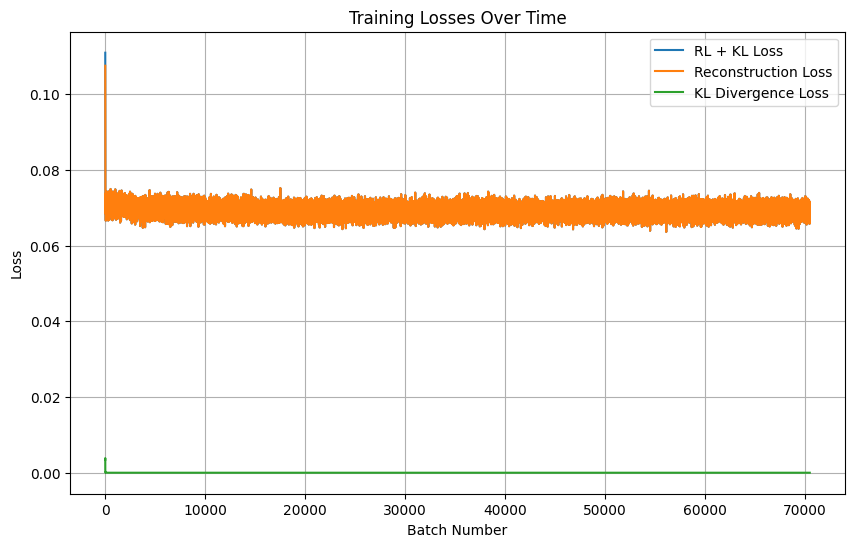

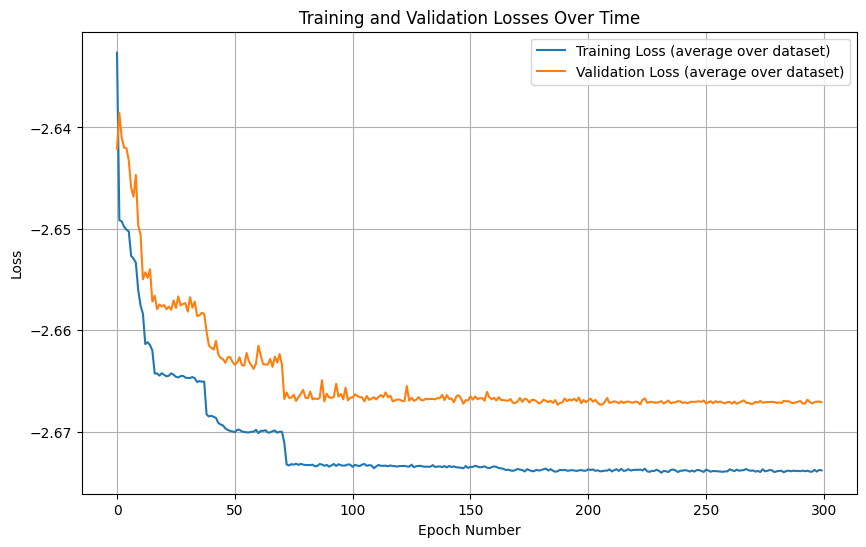

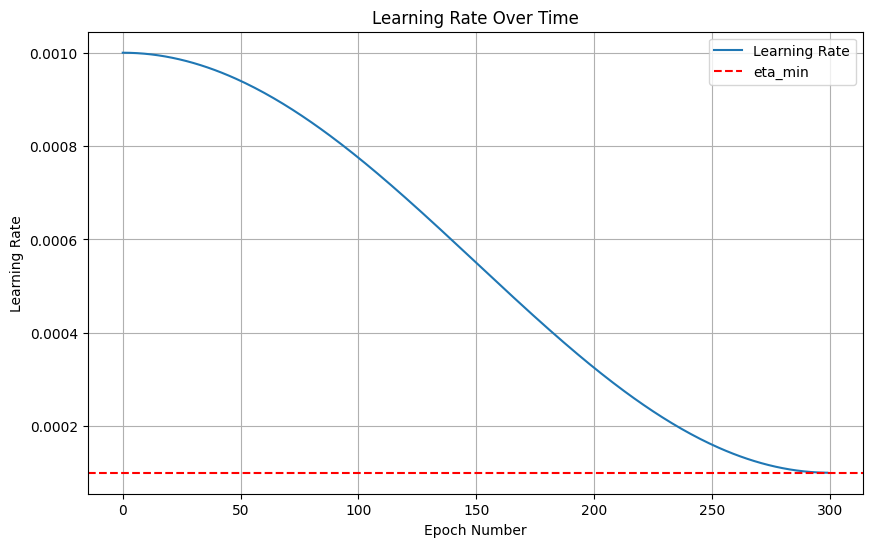

In [3]:
class Decoder(nn.Module):
    f"""
    Variational Autoencoder Decoder
    Given a latent vector z that is normally distributed from the encoder params
    infer the p(x | z) where x \in R^output_dim and z \in R^latent_dim
    p(z) ~ N(0, I) where I is the identity matrix
    """
    def __init__(self, latent_dim=2, output_dim=784):
        super(Decoder, self).__init__()
        # currently the latent vector is 2D for testing
        # the decoder is a simple MLP that is 2 layers deep 
        self.fc1 = torch.nn.Linear(latent_dim, 256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.fc3 = torch.nn.Linear(256, output_dim)
    
    def forward(self, z):
        h1 = F.relu(self.fc1(z))
        h2 = F.relu(self.fc2(h1))
        x_recon = F.relu(self.fc3(h2))
        return x_recon

class VariationalEncoder(nn.Module):
    """
    Variational Encoder ~ trained using variational inference on the posterior p(z | x)
    we approximate this using this encoder neural network q(z | x) = N(z | mu, sigma * I), where z \in R^latent_dim
    and mu \in R^latent_dim and sigma is real valued
    """
    def __init__(self, latent_dim=2, output_dim=784):
        super(VariationalEncoder, self).__init__()
        # currently the latent vector is 2D for testing
        # the encoder is a simple MLP that is 2 layers deep
        self.fc1 = torch.nn.Linear(output_dim, 256)
        self.fc2 = torch.nn.Linear(256, 256)
        # separate outputs for mean and log variance
        self.fc_mu = torch.nn.Linear(256, latent_dim)
        self.fc_logvar = torch.nn.Linear(256, latent_dim)
    
    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, sigma)
        """
        std = torch.exp(0.5 * logvar) # gives the standard deviation
        eps = torch.randn_like(std)
        return mu + eps * std

class VAE(nn.Module):
    def __init__(self, latent_dim=2, output_dim=784):
        super(VAE, self).__init__()
        self.encoder = VariationalEncoder(latent_dim, output_dim)
        self.decoder = Decoder(latent_dim, output_dim)
        
    
    def forward(self, x):
        mu, logvar = self.encoder(x) # returns the mean and log variance of the posterior
        z = self.encoder.reparameterize(mu, logvar) # sampling from the variational posterior
        x_recon = self.decoder(z)
        return x_recon, mu, logvar
    
    def loss_function(self, x_recon, x, mu, logvar, batch_size, kl_prior_scale=0.002):
        # want to minimize the Evidence Lower Bound (ELBO)
        # and the reconstruction loss, with 
        #recon_loss = F.mse_loss(x_recon, x)
        recon_loss = F.mse_loss(x_recon, x)

        # KL divergence between and q(z|x) and p(z|x) , sampled from q(z|x)
        # E_z~q(log(q(z|x)) - log p(z|x))
        # the second term is the normal(mean, variance) prior
        kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

        return recon_loss + KL_PRIOR_SCALE  * kl_loss, recon_loss, KL_PRIOR_SCALE * kl_loss


# HYPERPARAMETERS
LATENT_DIM = 2
LEARNING_RATE = 0.001
PRINT_EVERY = 100
N_EPOCHS = 300
ETA_MIN = 0.0001
SEED = 42
BATCH_SIZE = 256
KL_PRIOR_SCALE = 1.0

model = VAE(latent_dim=LATENT_DIM)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS, eta_min=ETA_MIN)

def train_vae(
        model,
        optimizer,
        scheduler,
        train_images,
        train_labels, 
        test_images, 
        test_labels, 
        n_epochs=N_EPOCHS, 
        batch_size=BATCH_SIZE, 
        print_every=PRINT_EVERY
    ):

    torch.manual_seed(SEED)

    train_dataset = TensorDataset(
        torch.from_numpy(train_images).float(), 
        torch.from_numpy(train_labels).float()
    )

    validation_dataset = TensorDataset(
        torch.from_numpy(test_images).float(), 
        torch.from_numpy(test_labels).float()
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    def computer_validation_loss(model, validation_loader):
        model.eval()
        total_validation_loss = 0.0
        n_validation_batches = len(validation_loader)
        for batch_idx, (batch_images, batch_labels) in enumerate(validation_loader):
            x_recon, mu, logvar = model(batch_images)
            loss, recon_loss, kl_loss = model.loss_function(x_recon, batch_images, mu, logvar, batch_size, KL_PRIOR_SCALE)
            total_validation_loss += loss.item()
        average_validation_loss = total_validation_loss / n_validation_batches
        return average_validation_loss

    # Lists to store losses for plotting
    # training losses
    batch_training_losses = []
    epoch_training_losses = []
    batch_training_recon_losses = []
    batch_training_kl_losses = []
    batch_numbers = []
    
    batch_counter = 0

    # validation losses
    learning_rates = []
    epoch_validation_losses = []
    epoch_numbers = []

    for epoch in range(n_epochs): # loop over the whole dataset
        model.train()
        total_epoch_loss = 0.0
        n_train_batches = len(train_loader)
        for batch_idx, (batch_images, batch_labels) in enumerate(train_loader):
            optimizer.zero_grad()
            x_recon, mu, logvar = model(batch_images)
            loss, recon_loss, kl_loss = model.loss_function(x_recon, batch_images, mu, logvar, batch_size)
            if batch_idx % print_every == 0:
                print(f"--Batch {batch_counter:6d} loss: {loss:.4e}, recon_loss: {recon_loss:.4e}, kl_loss: {kl_loss:.4e}")
            loss.backward()
            optimizer.step()
            total_epoch_loss += loss.item()
            
            # Store batch losses for plotting
            batch_training_losses.append(loss.item())
            batch_training_recon_losses.append(recon_loss.item())
            batch_training_kl_losses.append(kl_loss.item())
            batch_numbers.append(batch_counter)
            batch_counter += 1
        
        # model validation
        average_epoch_training_loss = total_epoch_loss / (n_train_batches)
        epoch_training_losses.append(np.log(average_epoch_training_loss))
        with torch.no_grad():
            average_validation_loss = computer_validation_loss(model, validation_loader)
            print(f"Epoch {epoch:4d} training loss: {average_epoch_training_loss:.4e} validation loss: {average_validation_loss:.4e} learning rate: {scheduler.get_last_lr()[0]:.3e}")
            epoch_validation_losses.append(np.log(average_validation_loss))
        
        learning_rates.append(scheduler.get_last_lr()[0])
        epoch_numbers.append(epoch)


        # update scheduler
        scheduler.step()
            
    
    # Plot the batch losses over time
    plt.figure(figsize=(10, 6))
    
    plt.plot(batch_numbers, batch_training_losses, label='RL + KL Loss')
    plt.plot(batch_numbers, batch_training_recon_losses, label='Reconstruction Loss')
    plt.plot(batch_numbers, batch_training_kl_losses, label='KL Divergence Loss')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.title('Training Losses Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the average epoch losses over time
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_numbers, epoch_training_losses, label='Training Loss (average over dataset)')
    plt.plot(epoch_numbers, epoch_validation_losses, label='Validation Loss (average over dataset)')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plot the learning rates over time
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_numbers, learning_rates, label='Learning Rate')
    plt.axhline(y=ETA_MIN, color='red', linestyle='--', label='eta_min')
    plt.xlabel('Epoch Number')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

train_vae(
    model, 
    optimizer,
    scheduler,
    train_images, 
    train_labels, 
    test_images,
    test_labels
)


# Sample from VAE - reconstruction check

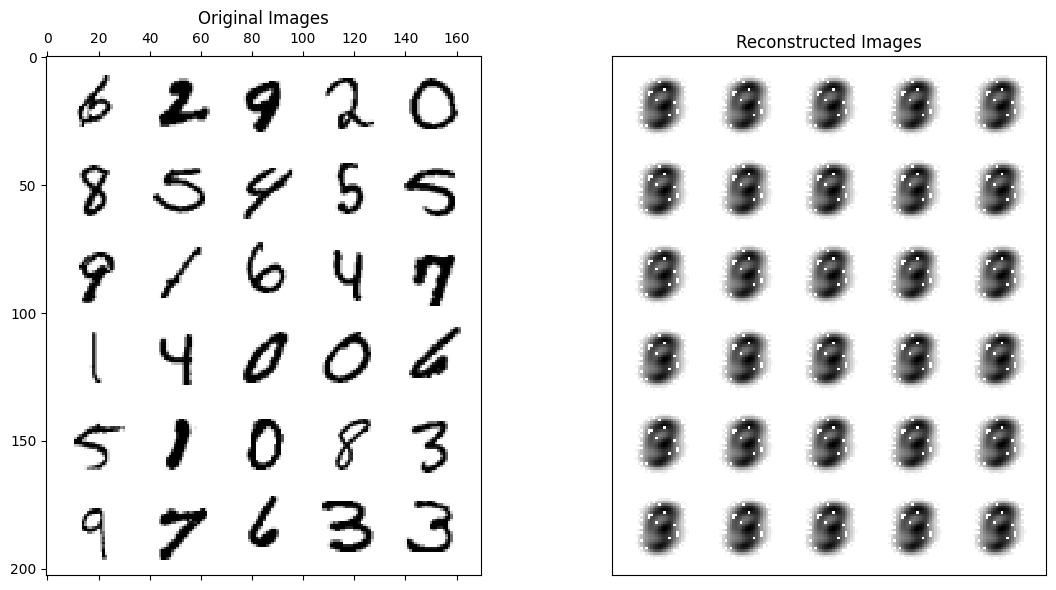

In [4]:
NUM_SAMPLES = 30
indices = np.random.choice(train_images.shape[0], NUM_SAMPLES, replace=False)

# Create subplots to show both original and reconstructed images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot original images
plot_images(train_images[indices], ax1)
ax1.set_title('Original Images')

train_images_tensor = torch.from_numpy(train_images).float()
x_recon, mu, logvar = model.forward(train_images_tensor[indices])

# convert x_recon to numpy
x_recon_np = x_recon.detach().numpy()

# Plot reconstructed images
plot_images(x_recon_np, ax2)
ax2.set_title('Reconstructed Images')

plt.tight_layout()
plt.show()

# Randomly sample from VAE

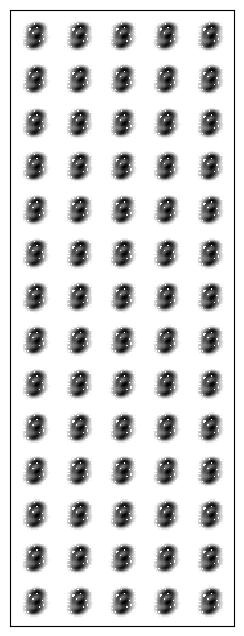

In [5]:
# randomly sample a latent vector z and decode it
z = torch.randn(70, LATENT_DIM)  # sample 10 random latent vectors
x_sampled = model.decoder(z)

# convert to numpy and plot
x_sampled_np = x_sampled.detach().numpy()

# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))
plot_images(x_sampled_np, ax)
plt.show()


# Plot latent points by class

In [116]:
type(test_labels)

numpy.ndarray

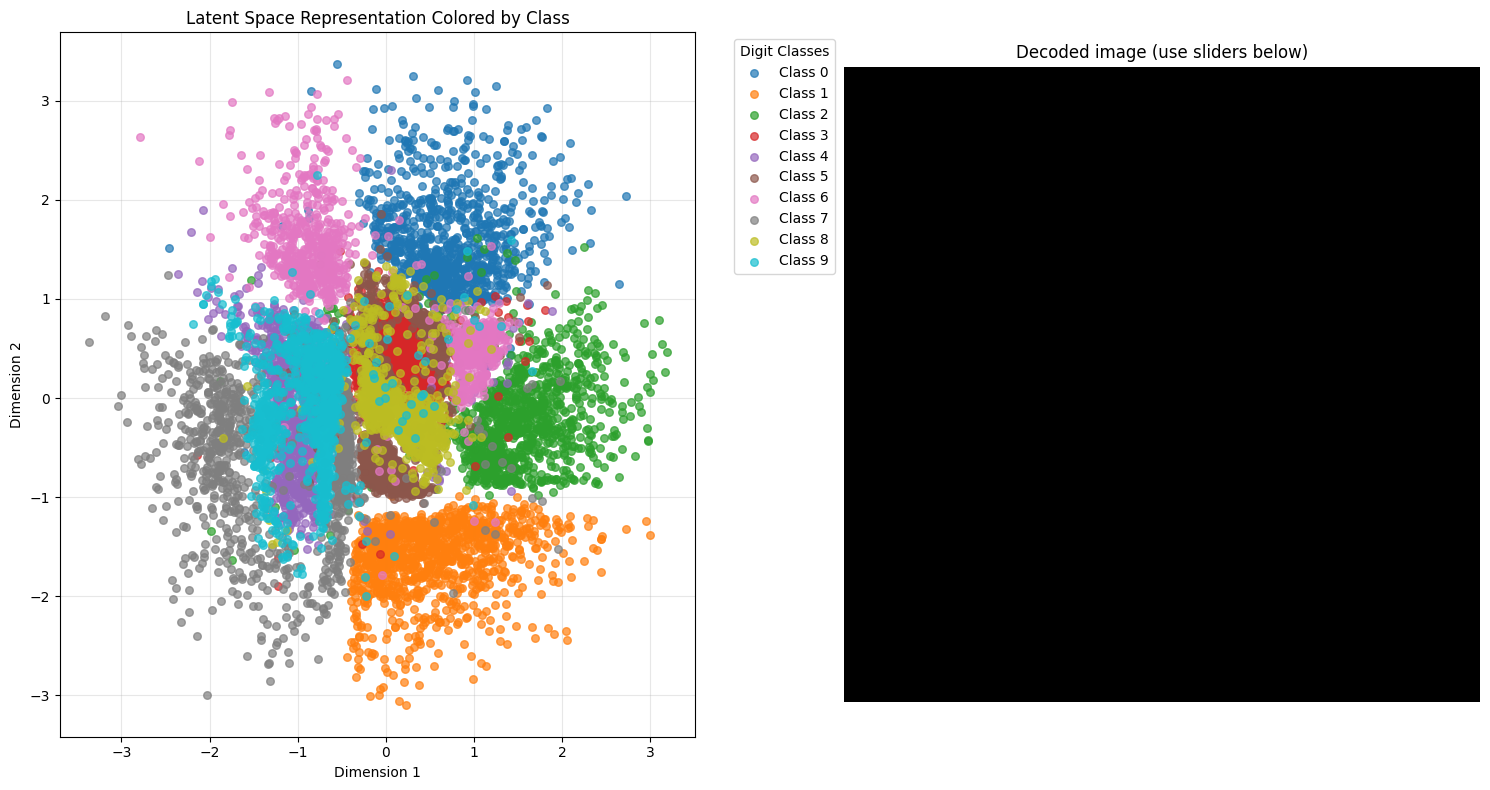

In [ ]:
def plot_latent_space(plot_uncertainty=True, interactive=True):
    # Plot latent space points in 2D with colors determined by one-hot vectors
    if interactive:
        # Use ipywidgets for interactivity in Jupyter/VSCode environment
        from IPython.display import display
        import ipywidgets as widgets
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    else:
        fig, ax1 = plt.subplots(figsize=(10, 8))

    # Encode test data to get latent coordinates
    mu, logvar = model.encoder(torch.tensor(test_images, dtype=torch.float32))

    # Extract x and y coordinates from the mu (mean of 2D gaussian)
    x_coords = mu[:, 0].detach().numpy()
    y_coords = mu[:, 1].detach().numpy()

    # Extract standard deviations from logvar (sigma = exp(0.5 * logvar))
    sigma_x = torch.exp(0.5 * logvar[:, 0]).detach().numpy()
    sigma_y = torch.exp(0.5 * logvar[:, 1]).detach().numpy()

    # Create one-hot vectors of shape (n_points, 10)
    one_hot_colors = test_labels

    # Get colors from the one-hot vectors
    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    # Plot points with colors determined by one-hot vectors
    for class_idx in range(10):
        # Find points belonging to this class
        mask = one_hot_colors[:, class_idx] == 1
        if np.any(mask):
            # Plot the mean points
            ax1.scatter(x_coords[mask], y_coords[mask], c=[colors[class_idx]], 
                    label=f'Class {class_idx}', alpha=0.7, s=30, zorder=2)
            
            # Add uncertainty ellipses for first standard deviation
            if plot_uncertainty:
                for i in np.where(mask)[0]:
                    # Create ellipse representing 1 standard deviation
                    ellipse = plt.matplotlib.patches.Ellipse(
                        (x_coords[i], y_coords[i]), 
                        width=2*sigma_x[i], height=2*sigma_y[i],
                        facecolor=colors[class_idx], alpha=0.1, 
                        edgecolor=colors[class_idx], linewidth=0.5, zorder=1
                    )
                    ax1.add_patch(ellipse)

    ax1.set_xlabel('Dimension 1')
    ax1.set_ylabel('Dimension 2')
    title = 'Latent Space Representation Colored by Class'
    if plot_uncertainty:
        title += ' with Uncertainty'
    ax1.set_title(title)
    ax1.legend(title='Digit Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)

    if interactive:
        # Set up the second subplot for decoded images
        ax2.set_title('Decoded image (click a point or use sliders below)')
        ax2.axis('off')
        
        # Create initial empty image
        empty_img = np.zeros((28, 28))
        im = ax2.imshow(empty_img, cmap='gray', vmin=0, vmax=1)
        
        # Get the range of latent coordinates for sliders
        x_min, x_max = x_coords.min(), x_coords.max()
        y_min, y_max = y_coords.min(), y_coords.max()
        
        # Add some padding to the ranges
        x_range = x_max - x_min
        y_range = y_max - y_min
        x_min -= 0.2 * x_range
        x_max += 0.2 * x_range
        y_min -= 0.2 * y_range
        y_max += 0.2 * y_range
        
        plt.tight_layout()
        plt.show()
        
        # Create interactive sliders that update the image in ax2
        def update_image(x_val, y_val):
            # Create latent vector from slider values
            z = torch.tensor([[x_val, y_val]], dtype=torch.float32)
            
            # Decode the latent vector
            with torch.no_grad():
                decoded = model.decoder(z)
                decoded_img = decoded.squeeze().numpy().reshape(28, 28)
            
            # Update the existing image in ax2
            im.set_data(decoded_img)
            ax2.set_title(f'Decoded image at ({x_val:.2f}, {y_val:.2f})')
            fig.canvas.draw()
        
        # Create sliders
        x_slider = widgets.FloatSlider(
            value=0.0,
            min=x_min,
            max=x_max,
            step=0.1,
            description='X coord:',
            continuous_update=True
        )
        
        y_slider = widgets.FloatSlider(
            value=0.0,
            min=y_min,
            max=y_max,
            step=0.1,
            description='Y coord:',
            continuous_update=True
        )
        
        # Create and display the interactive widget
        interactive_widget = widgets.interactive(update_image, x_val=x_slider, y_val=y_slider)
        display(interactive_widget)
        
    else:
        plt.tight_layout()
        plt.show()

plot_latent_space(plot_uncertainty=False, interactive=True)


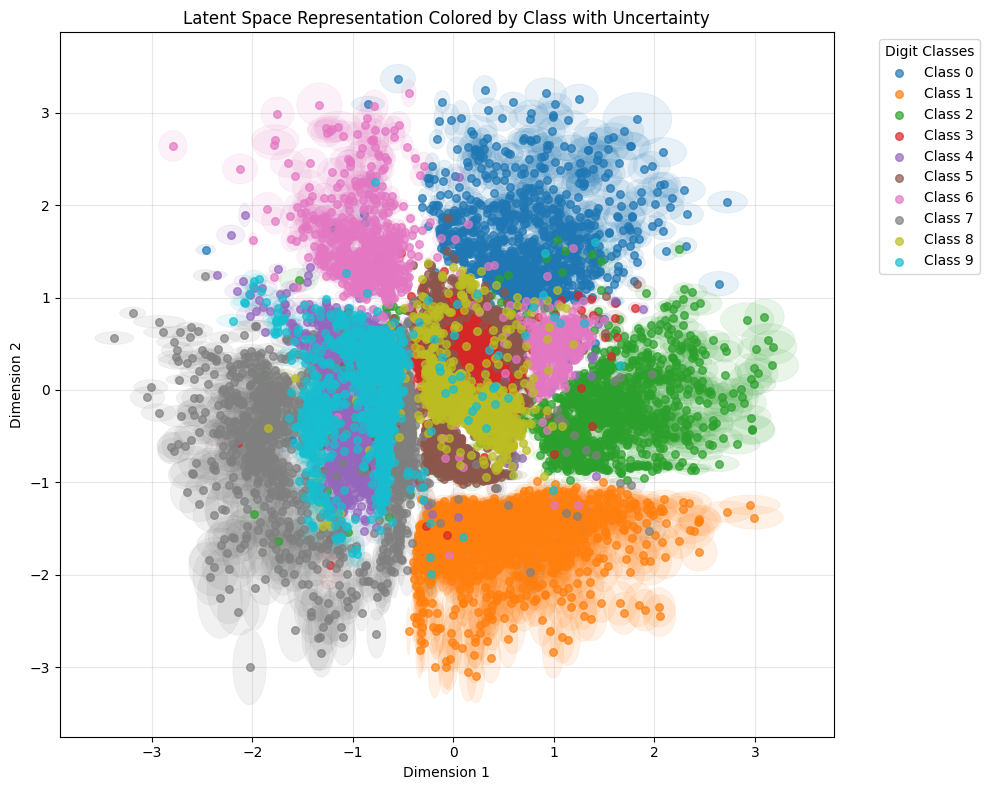

In [124]:
def plot_latent_space(plot_uncertainty=True):
    # Plot latent space points in 2D with colors determined by one-hot vectors
    fig, ax = plt.subplots(figsize=(10, 8))

    # Encode test data to get latent coordinates
    mu, logvar = model.encoder(torch.tensor(test_images, dtype=torch.float32))

    # Extract x and y coordinates from the mu (mean of 2D gaussian)
    x_coords = mu[:, 0].detach().numpy()
    y_coords = mu[:, 1].detach().numpy()

    # Extract standard deviations from logvar (sigma = exp(0.5 * logvar))
    sigma_x = torch.exp(0.5 * logvar[:, 0]).detach().numpy()
    sigma_y = torch.exp(0.5 * logvar[:, 1]).detach().numpy()

    # Create one-hot vectors of shape (n_points, 10)
    one_hot_colors = test_labels

    # Get colors from the one-hot vectors
    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    # Plot points with colors determined by one-hot vectors
    for class_idx in range(10):
        # Find points belonging to this class
        mask = one_hot_colors[:, class_idx] == 1
        if np.any(mask):
            # Plot the mean points
            ax.scatter(x_coords[mask], y_coords[mask], c=[colors[class_idx]], 
                    label=f'Class {class_idx}', alpha=0.7, s=30, zorder=2)
            
            # Add uncertainty ellipses for first standard deviation
            if plot_uncertainty:
                for i in np.where(mask)[0]:
                    # Create ellipse representing 1 standard deviation
                    ellipse = plt.matplotlib.patches.Ellipse(
                        (x_coords[i], y_coords[i]), 
                        width=2*sigma_x[i], height=2*sigma_y[i],
                        facecolor=colors[class_idx], alpha=0.1, 
                        edgecolor=colors[class_idx], linewidth=0.5, zorder=1
                    )
                    ax.add_patch(ellipse)

    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    title = 'Latent Space Representation Colored by Class'
    if plot_uncertainty:
        title += ' with Uncertainty'
    ax.set_title(title)
    ax.legend(title='Digit Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_latent_space()
